## Read and Process CMIP6 data
This notebook contains code to pre-process the CMIP6 data used in later analyses, including:
- regridding data to 5x5 grid
- calculating moving averages
- calculating forced response (ensemble mean)
- calculating grid-cell mean and standard deviations. Mean and s.d. are calculated for each variant after subtracting the forced response 
- calculating terciles (1/3 and 2/3 quantiles) for each variant. Terciles are calculated after subtracting the forced response and standardizing with the mean and s.d. 

Also saves some general data for later use:
- lat values
- lon values
- dates
- land mask for each model

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import xarray as xr
import xesmf as xe

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
from project_utils import preprocess_utils as preprocess
from project_utils.variant_dict import VARIANT_DICT, test_index

In [4]:
import seaborn as sns

### Create destination grid
Input is regridded to a 5x5 lat-lon grid

In [5]:
out_res = 5
out_grid = xr.Dataset({'lat': (['lat'], np.arange(-90+out_res/2, 90+out_res/2, out_res)), 
                      'lon': (['lon'], np.arange(0+out_res/2, 360+out_res/2, out_res))})

## save lat-lon values to .csv
out_grid.lat.to_dataframe().to_csv("../processed_data/lat_5x5.csv", index = False)
out_grid.lon.to_dataframe().to_csv("../processed_data/lon_5x5.csv", index = False)
out_grid.to_netcdf("../processed_data/grid_5x5.nc")
out_grid

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72)
Coordinates:
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Data variables:
    *empty*

In [6]:
## Set rolling windows to calculate (in number of months)
windows = [12, 36, 60]

#### Plot pre-processed data

In [7]:
# lat-lon points for QA/QC plotting
qa_points = [(47.5, 172.5), (2.5, 192.5), (-62.5, 242.5), (57.5, 332.5), (-37.5, 42.5)]
location_labels = ["North Pacific (47.5N, 172.5E)", "Tropical Pacific (2.5N, 167.5W)", "Southern Ocean (67.5S, 117.5W)",
                   "North Atlantic (57.5N, 27.5W)", "SW Indian Ocean (37.5S, 42.5E)"] 

In [8]:
def plot_anomaly_ts(points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW):
    ## lat/lon points to plot, given as list of tuples
      
    dat = [] 
    test_variants = VARIANT_DICT[MODEL][test_index]
    for v in test_variants:
        ds = xr.open_dataset("../processed_data/CMIP6/"+VAR_NAME+\
                             "_monthly_"+MODEL+"_"+EXP+"_"+v+"_"+str(out_res)+"x"+str(out_res)+"_"+str(WINDOW)+"month.nc", chunks = "auto")
        ds_fr = xr.open_dataset("../processed_data/CMIP6/"+VAR_NAME+\
                           "_monthly_"+MODEL+"_"+EXP+"_"+str(out_res)+"x"+str(out_res)+"_"+str(WINDOW)+"month_forced_response.nc", chunks = "auto")
        ds_mean = xr.open_dataset("../processed_data/CMIP6/"+VAR_NAME+"_monthly_"+MODEL+"_"+EXP+"_"+v+"_"+str(out_res)+"x"+str(out_res)+"_"+str(WINDOW)+"month_mean.nc", chunks = "auto")
        ds_sd = xr.open_dataset("../processed_data/CMIP6/"+VAR_NAME+"_monthly_"+MODEL+"_"+EXP+"_"+v+"_"+str(out_res)+"x"+str(out_res)+"_"+str(WINDOW)+"month_sd.nc", chunks = "auto")
        ds = (ds - ds_fr - ds_mean)/ds_sd
        ds = ds.assign_coords({"variant": v})
        dat.append(ds)
    dat = xr.concat(dat, dim = "variant")    
   
    fig, axes = plt.subplots(figsize = (5, 12), nrows = len(points), ncols = 1)
    
    for i, p in enumerate(points):
        axes[i].axhline(0, c = "k", linestyle = ":", zorder = 1)
        for v in range(len(test_variants)):
            dat.sel(lat = p[0], lon = p[1]).isel(variant = v).tos.plot(ax=axes[i], color = sns.color_palette("mako", n_colors=len(test_variants))[v], zorder = 5)
        axes[i].set_title(location_labels[i])
    plt.suptitle(MODEL, fontweight="bold")
    plt.tight_layout()
    plt.savefig("../figures/preprocessing/timeseries_"+MODEL+"_"+str(WINDOW)+"mo.pdf")

## ACCESS-ESM1-5 TOS

In [9]:
MODEL = "ACCESS-ESM1-5"
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
VARIANTS = VARIANT_DICT[MODEL]
GRID = "gn"

In [10]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p1f1 not regridding r2i1p1f1 not regridding r3i1p1f1 not regridding r4i1p1f1 not regridding r5i1p1f1 not regridding r6i1p1f1 not regridding r7i1p1f1 not regridding r8i1p1f1 not regridding r9i1p1f1 not regridding r10i1p1f1 not regridding r11i1p1f1 not regridding r12i1p1f1 not regridding r13i1p1f1 not regridding r14i1p1f1 not regridding r15i1p1f1 not regridding r16i1p1f1 not regridding r17i1p1f1 not regridding r18i1p1f1 not regridding r19i1p1f1 not regridding r20i1p1f1 not regridding r21i1p1f1 not regridding r22i1p1f1 not regridding r23i1p1f1 not regridding r24i1p1f1 not regridding r25i1p1f1 not regridding r26i1p1f1 not regridding r27i1p1f1 not regridding r28i1p1f1 not regridding r29i1p1f1 not regridding r30i1p1f1 not regridding r1i1p1f1 not recalculating moving average r2i1p1f1 not recalculating moving average r3i1p1f1 not recalculating moving average r4i1p1f1 not recalculating moving average r5i1p1f1 not recalculating moving average r6i1p1f1 not recalculating moving average r7i1p1f

In [11]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

## save date timeseries (only need to do this once, not for every model)
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_"+VARIANTS[0]+"_18500101_20141231_5x5.nc")
ds.time.to_dataframe().to_csv("../processed_data/cmip_date_timeseries.csv", index = False)

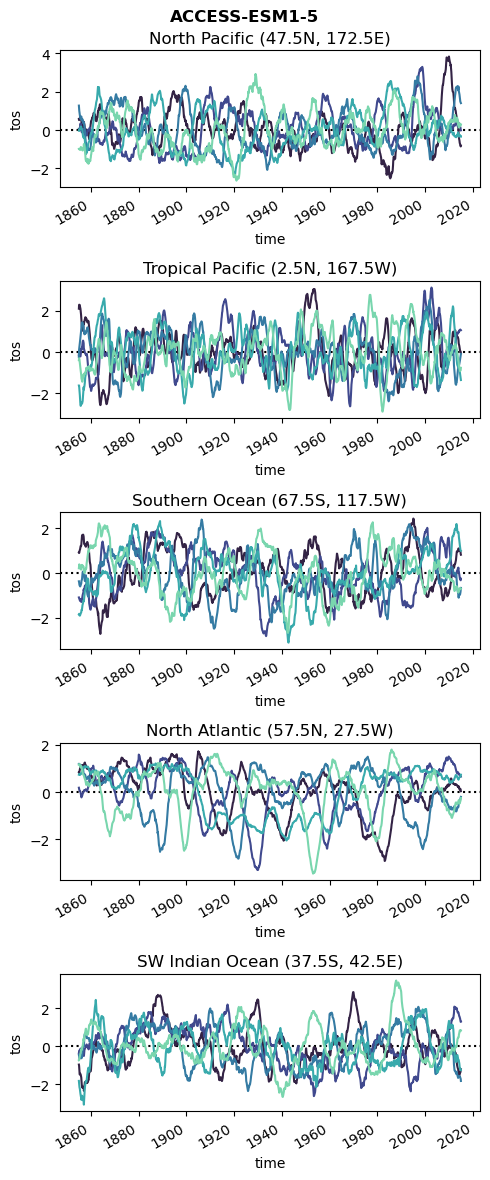

In [12]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)

## CNRM-CM6-1

In [13]:
MODEL = "CNRM-CM6-1"
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
VARIANTS = VARIANT_DICT[MODEL]
GRID = "gn"

In [14]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p1f2 not regridding r2i1p1f2 not regridding r3i1p1f2 not regridding r4i1p1f2 not regridding r5i1p1f2 not regridding r6i1p1f2 not regridding r7i1p1f2 not regridding r8i1p1f2 not regridding r9i1p1f2 not regridding r10i1p1f2 not regridding r11i1p1f2 not regridding r12i1p1f2 not regridding r13i1p1f2 not regridding r14i1p1f2 not regridding r15i1p1f2 not regridding r16i1p1f2 not regridding r17i1p1f2 not regridding r18i1p1f2 not regridding r19i1p1f2 not regridding r20i1p1f2 not regridding r21i1p1f2 not regridding r22i1p1f2 not regridding r23i1p1f2 not regridding r24i1p1f2 not regridding r25i1p1f2 not regridding r26i1p1f2 not regridding r27i1p1f2 not regridding r28i1p1f2 not regridding r29i1p1f2 not regridding r30i1p1f2 not regridding r1i1p1f2 not recalculating moving average r2i1p1f2 not recalculating moving average r3i1p1f2 not recalculating moving average r4i1p1f2 not recalculating moving average r5i1p1f2 not recalculating moving average r6i1p1f2 not recalculating moving average r7i1p1f

In [15]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

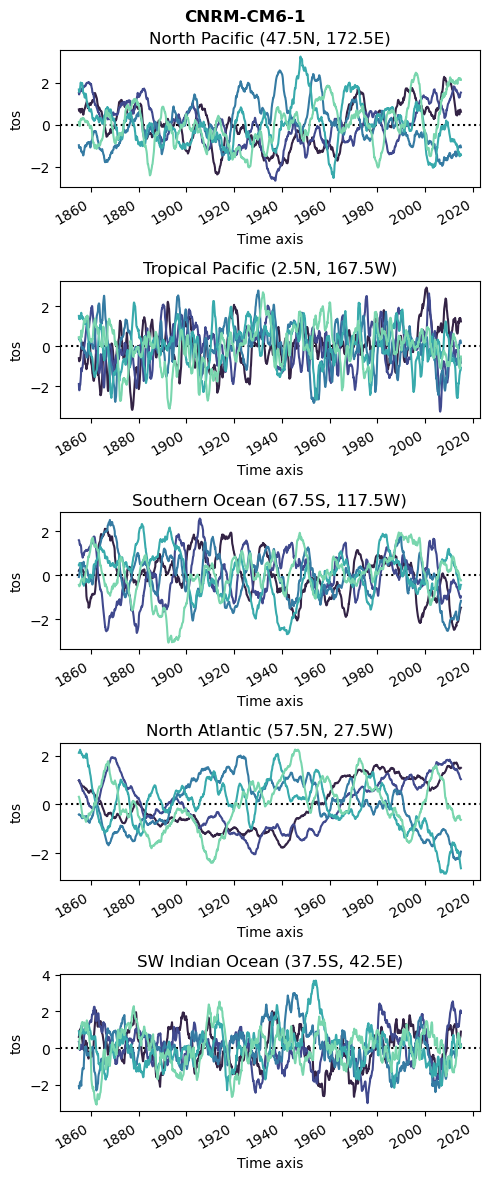

In [16]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)

## CanESM5

In [17]:
MODEL = "CanESM5"
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
VARIANTS = VARIANT_DICT[MODEL]
GRID = "gn"

In [18]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p2f1 not regridding r2i1p2f1 not regridding r3i1p2f1 not regridding r4i1p2f1 not regridding r5i1p2f1 not regridding r6i1p2f1 not regridding r7i1p2f1 not regridding r8i1p2f1 not regridding r9i1p2f1 not regridding r10i1p2f1 not regridding r11i1p2f1 not regridding r12i1p2f1 not regridding r13i1p2f1 not regridding r14i1p2f1 not regridding r15i1p2f1 not regridding r16i1p2f1 not regridding r17i1p2f1 not regridding r18i1p2f1 not regridding r19i1p2f1 not regridding r20i1p2f1 not regridding r21i1p2f1 not regridding r22i1p2f1 not regridding r23i1p2f1 not regridding r24i1p2f1 not regridding r25i1p2f1 not regridding r26i1p2f1 not regridding r27i1p2f1 not regridding r28i1p2f1 not regridding r29i1p2f1 not regridding r30i1p2f1 not regridding r1i1p2f1 not recalculating moving average r2i1p2f1 not recalculating moving average r3i1p2f1 not recalculating moving average r4i1p2f1 not recalculating moving average r5i1p2f1 not recalculating moving average r6i1p2f1 not recalculating moving average r7i1p2f

In [19]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

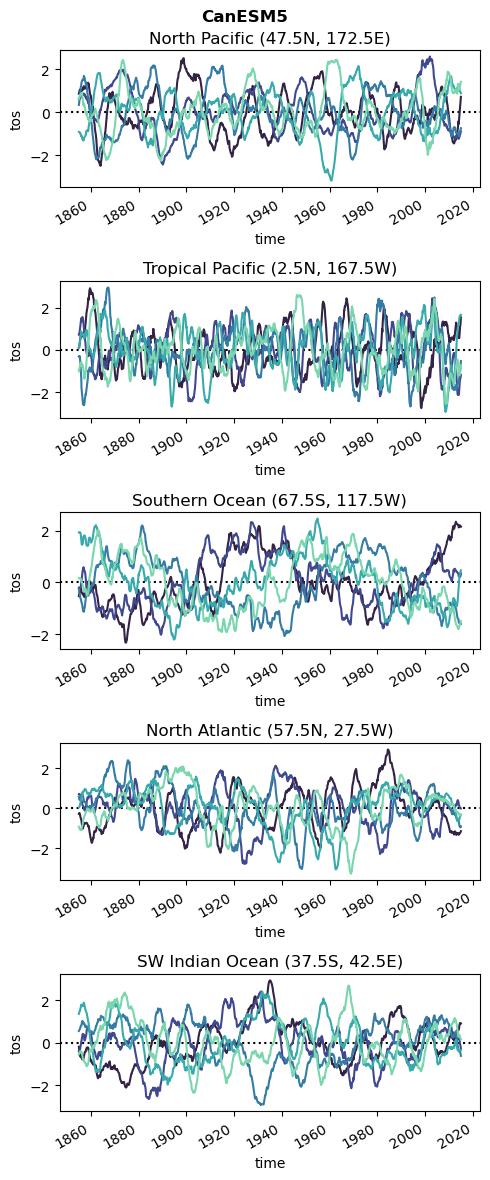

In [20]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)

## GISS-E2-1-G

In [21]:
MODEL = "GISS-E2-1-G"
VARIANTS = VARIANT_DICT[MODEL]
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
GRID = "gn"

In [22]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p1f1 not regridding r2i1p1f1 not regridding r3i1p1f1 not regridding r4i1p1f1 not regridding r5i1p1f1 not regridding r6i1p1f1 not regridding r7i1p1f1 not regridding r8i1p1f1 not regridding r9i1p1f1 not regridding r10i1p1f1 not regridding r1i1p3f1 not regridding r2i1p3f1 not regridding r3i1p3f1 not regridding r4i1p3f1 not regridding r5i1p3f1 not regridding r6i1p3f1 not regridding r8i1p3f1 not regridding r9i1p3f1 not regridding r10i1p3f1 not regridding r1i1p5f1 not regridding r2i1p5f1 not regridding r3i1p5f1 not regridding r4i1p5f1 not regridding r101i1p1f1 not regridding r102i1p1f1 not regridding r1i1p1f2 not regridding r2i1p1f2 not regridding r3i1p1f2 not regridding r4i1p1f2 not regridding r5i1p1f2 not regridding r1i1p1f1 not recalculating moving average r2i1p1f1 not recalculating moving average r3i1p1f1 not recalculating moving average r4i1p1f1 not recalculating moving average r5i1p1f1 not recalculating moving average r6i1p1f1 not recalculating moving average r7i1p1f1 not recalcula

In [23]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

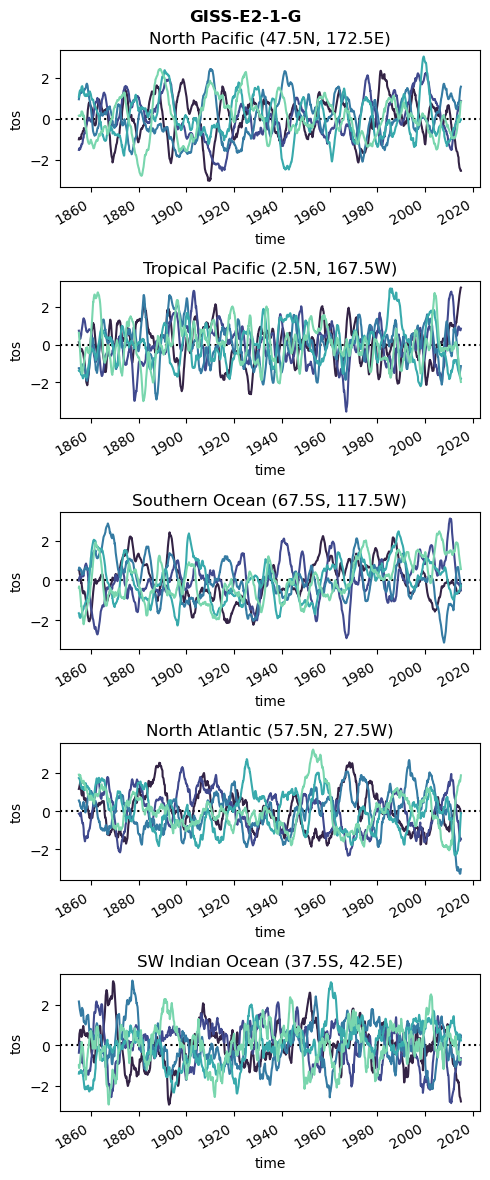

In [24]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)

## IPSL-CM6A-LR

In [25]:
MODEL = "IPSL-CM6A-LR"
VARIANTS = VARIANT_DICT[MODEL]
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
GRID = "gn"

In [26]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p1f1 not regridding r2i1p1f1 not regridding r3i1p1f1 not regridding r4i1p1f1 not regridding r5i1p1f1 not regridding r6i1p1f1 not regridding r7i1p1f1 not regridding r8i1p1f1 not regridding r9i1p1f1 not regridding r10i1p1f1 not regridding r11i1p1f1 not regridding r12i1p1f1 not regridding r13i1p1f1 not regridding r14i1p1f1 not regridding r15i1p1f1 not regridding r16i1p1f1 not regridding r17i1p1f1 not regridding r18i1p1f1 not regridding r19i1p1f1 not regridding r20i1p1f1 not regridding r21i1p1f1 not regridding r22i1p1f1 not regridding r23i1p1f1 not regridding r24i1p1f1 not regridding r25i1p1f1 not regridding r26i1p1f1 not regridding r27i1p1f1 not regridding r28i1p1f1 not regridding r29i1p1f1 not regridding r30i1p1f1 not regridding r1i1p1f1 not recalculating moving average r2i1p1f1 not recalculating moving average r3i1p1f1 not recalculating moving average r4i1p1f1 not recalculating moving average r5i1p1f1 not recalculating moving average r6i1p1f1 not recalculating moving average r7i1p1f

In [27]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

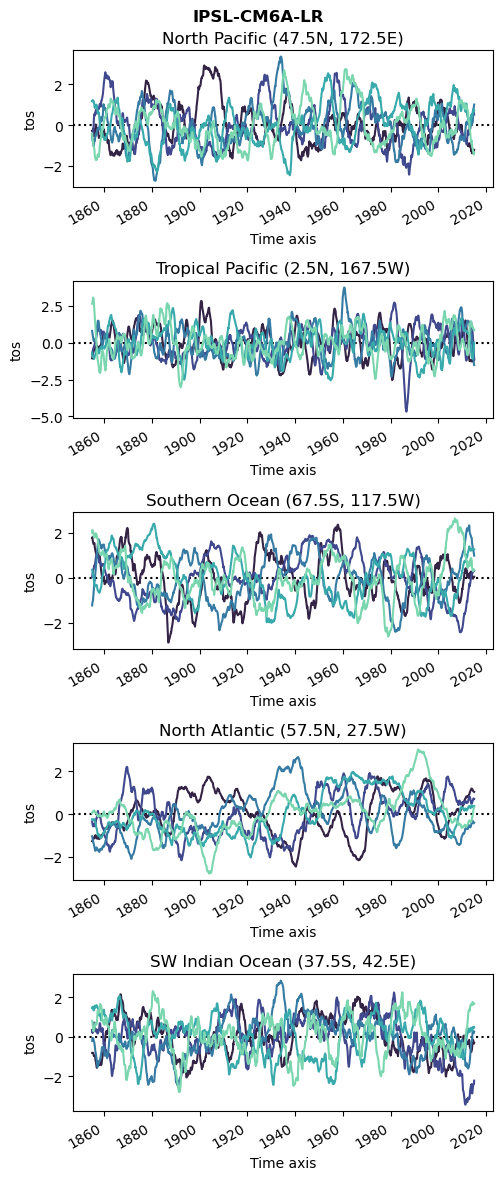

In [28]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)

## MIROC-ES2L

In [29]:
MODEL = "MIROC-ES2L"
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
VARIANTS = VARIANT_DICT[MODEL]
GRID = "gr1"

In [30]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p1f2 not regridding r2i1p1f2 not regridding r3i1p1f2 not regridding r4i1p1f2 not regridding r5i1p1f2 not regridding r6i1p1f2 not regridding r7i1p1f2 not regridding r8i1p1f2 not regridding r9i1p1f2 not regridding r10i1p1f2 not regridding r11i1p1f2 not regridding r12i1p1f2 not regridding r13i1p1f2 not regridding r14i1p1f2 not regridding r15i1p1f2 not regridding r16i1p1f2 not regridding r17i1p1f2 not regridding r18i1p1f2 not regridding r19i1p1f2 not regridding r20i1p1f2 not regridding r21i1p1f2 not regridding r22i1p1f2 not regridding r23i1p1f2 not regridding r24i1p1f2 not regridding r25i1p1f2 not regridding r26i1p1f2 not regridding r27i1p1f2 not regridding r28i1p1f2 not regridding r29i1p1f2 not regridding r30i1p1f2 not regridding r1i1p1f2 not recalculating moving average r2i1p1f2 not recalculating moving average r3i1p1f2 not recalculating moving average r4i1p1f2 not recalculating moving average r5i1p1f2 not recalculating moving average r6i1p1f2 not recalculating moving average r7i1p1f

In [31]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

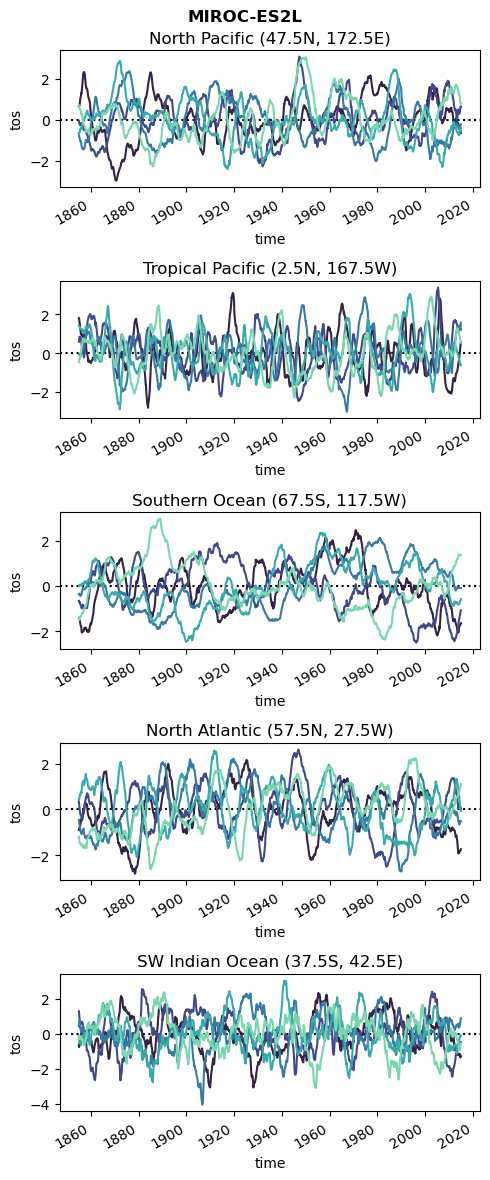

In [32]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)

## MIROC6

In [33]:
MODEL = "MIROC6"
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
VARIANTS = VARIANT_DICT[MODEL]
GRID = "gn"

In [34]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p1f1 not regridding r2i1p1f1 not regridding r3i1p1f1 not regridding r4i1p1f1 not regridding r5i1p1f1 not regridding r6i1p1f1 not regridding r7i1p1f1 not regridding r8i1p1f1 not regridding r9i1p1f1 not regridding r10i1p1f1 not regridding r11i1p1f1 not regridding r12i1p1f1 not regridding r13i1p1f1 not regridding r14i1p1f1 not regridding r15i1p1f1 not regridding r16i1p1f1 not regridding r17i1p1f1 not regridding r18i1p1f1 not regridding r19i1p1f1 not regridding r20i1p1f1 not regridding r21i1p1f1 not regridding r22i1p1f1 not regridding r23i1p1f1 not regridding r24i1p1f1 not regridding r25i1p1f1 not regridding r26i1p1f1 not regridding r27i1p1f1 not regridding r28i1p1f1 not regridding r29i1p1f1 not regridding r30i1p1f1 not regridding r1i1p1f1 not recalculating moving average r2i1p1f1 not recalculating moving average r3i1p1f1 not recalculating moving average r4i1p1f1 not recalculating moving average r5i1p1f1 not recalculating moving average r6i1p1f1 not recalculating moving average r7i1p1f

In [35]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

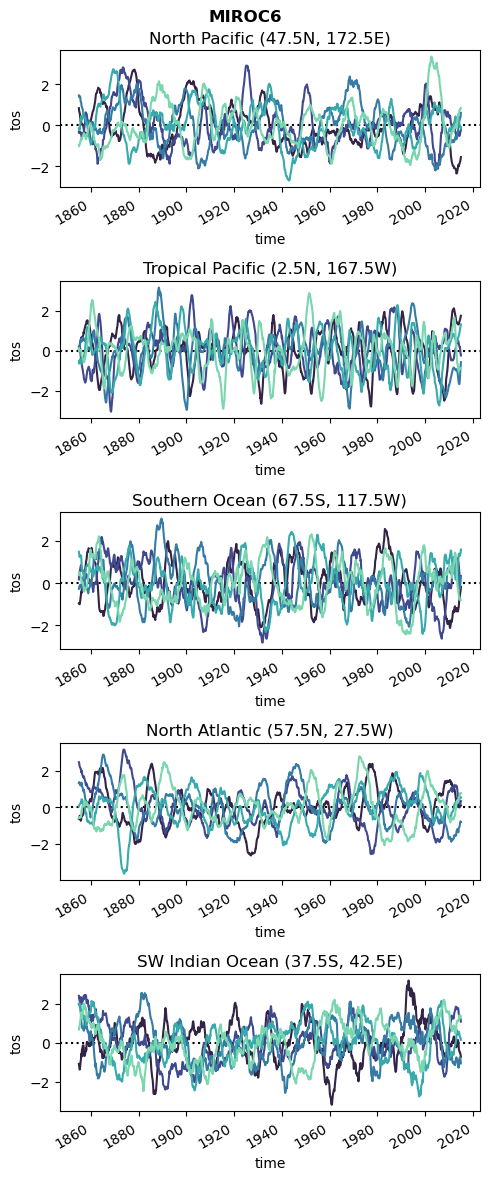

In [36]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)

## MPI-ESM1-2-LR

In [37]:
MODEL = "MPI-ESM1-2-LR"
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
VARIANTS = VARIANT_DICT[MODEL]
GRID = "gn"

In [38]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p1f1 not regridding r2i1p1f1 not regridding r3i1p1f1 not regridding r4i1p1f1 not regridding r5i1p1f1 not regridding r6i1p1f1 not regridding r7i1p1f1 not regridding r8i1p1f1 not regridding r9i1p1f1 not regridding r10i1p1f1 not regridding r11i1p1f1 not regridding r12i1p1f1 not regridding r13i1p1f1 not regridding r14i1p1f1 not regridding r15i1p1f1 not regridding r16i1p1f1 not regridding r17i1p1f1 not regridding r18i1p1f1 not regridding r19i1p1f1 not regridding r20i1p1f1 not regridding r21i1p1f1 not regridding r22i1p1f1 not regridding r23i1p1f1 not regridding r24i1p1f1 not regridding r25i1p1f1 not regridding r26i1p1f1 not regridding r27i1p1f1 not regridding r28i1p1f1 not regridding r29i1p1f1 not regridding r30i1p1f1 not regridding r1i1p1f1 not recalculating moving average r2i1p1f1 not recalculating moving average r3i1p1f1 not recalculating moving average r4i1p1f1 not recalculating moving average r5i1p1f1 not recalculating moving average r6i1p1f1 not recalculating moving average r7i1p1f

In [39]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

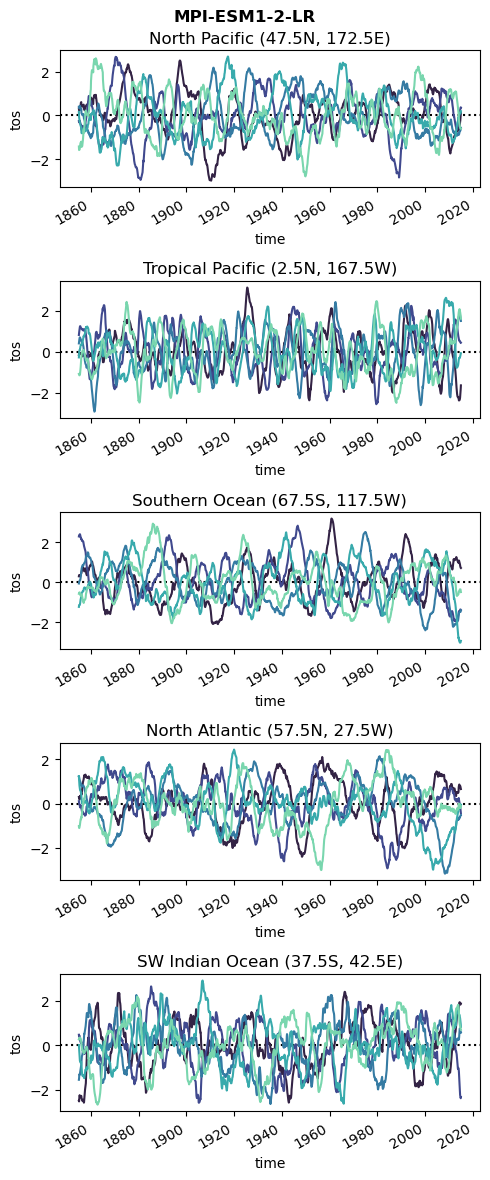

In [40]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)

## NorCPM1

In [41]:
MODEL = "NorCPM1"
VAR_NAME = "tos"
FREQ = "monthly"
EXP = "historical"
VARIANTS = VARIANT_DICT[MODEL]
GRID = "gn"

In [42]:
preprocess.regrid_save_files(out_grid, VARIANTS, VAR_NAME, FREQ, MODEL, EXP, GRID, OVERWRITE = False, OCEAN = True)
for window in windows:
    preprocess.calc_save_moving_average(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_forced_response(VARIANTS, VAR_NAME, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE = False)
    preprocess.calc_save_mean_sd(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, OVERWRITE=False)
    preprocess.calc_save_quantiles(VAR_NAME, VARIANTS, FREQ, MODEL, EXP, WINDOW = window, q = np.array([1/3, 2/3]), OVERWRITE = False)

r1i1p1f1 not regridding r2i1p1f1 not regridding r3i1p1f1 not regridding r4i1p1f1 not regridding r5i1p1f1 not regridding r6i1p1f1 not regridding r7i1p1f1 not regridding r8i1p1f1 not regridding r9i1p1f1 not regridding r10i1p1f1 not regridding r11i1p1f1 not regridding r12i1p1f1 not regridding r13i1p1f1 not regridding r14i1p1f1 not regridding r15i1p1f1 not regridding r16i1p1f1 not regridding r17i1p1f1 not regridding r18i1p1f1 not regridding r19i1p1f1 not regridding r20i1p1f1 not regridding r21i1p1f1 not regridding r22i1p1f1 not regridding r23i1p1f1 not regridding r24i1p1f1 not regridding r25i1p1f1 not regridding r26i1p1f1 not regridding r27i1p1f1 not regridding r28i1p1f1 not regridding r29i1p1f1 not regridding r30i1p1f1 not regridding r1i1p1f1 not recalculating moving average r2i1p1f1 not recalculating moving average r3i1p1f1 not recalculating moving average r4i1p1f1 not recalculating moving average r5i1p1f1 not recalculating moving average r6i1p1f1 not recalculating moving average r7i1p1f

In [43]:
## land mask
ds = xr.open_dataset("../processed_data/CMIP6/tos_monthly_"+MODEL+"_"+EXP+"_5x5_12month_forced_response.nc").isel(time = 20)
land_mask = xr.where(ds.tos.isnull(), 0, 1).rename("mask")
land_mask.to_netcdf("../processed_data/land_mask_5x5_"+MODEL+".nc")

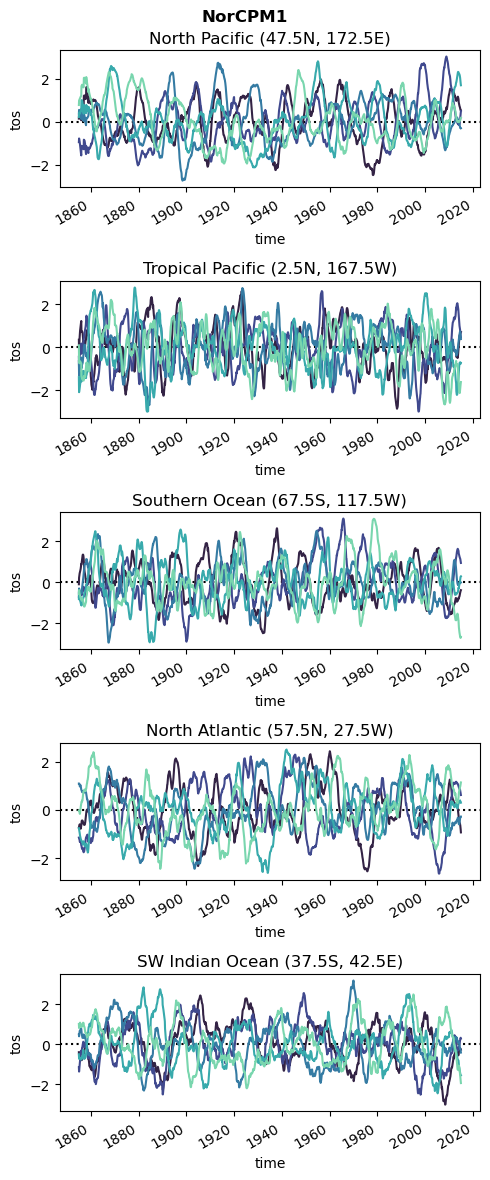

In [44]:
plot_anomaly_ts(qa_points, VAR_NAME, FREQ, EXP, MODEL, VARIANTS, WINDOW=60)